In [15]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import nltk
import string
import matplotlib.pyplot as plt

In [3]:
from sklearn import neighbors
from sklearn.decomposition import TruncatedSVD

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sn

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [7]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [8]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score,roc_curve

In [10]:
con=sqlite3.connect('final_data.sqlite')

In [11]:
## We had cleansed and saved the final data for TSNE assignment. We use the same for this assignment.

review_data=pd.read_sql_query("""Select * from  Reviews_without_Stemming""",con)
print(review_data.shape)

(364171, 12)


In [12]:
review_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really ros...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud- nice rhythm well...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute littl...


In [13]:
## Filter out Non Food related reviews
review_data=review_data[review_data['ProductId'].str.startswith('B')]
print(review_data.shape)

(363967, 12)


## Data Sample and Time based splitting

In [14]:
## To avoid Out of Memory error, let's sample some rows and try on the sample data
sampled_data=review_data[['Time','Score','CleanedText']].sample(100000)

In [20]:
# Sort the data based on time for time based splitting.
sampled_data_sort=sampled_data.sort_values('Time').reset_index(drop=True)

In [21]:
# Check the data again
print(sampled_data_sort.head())
sampled_data_sort['Score'].value_counts()

         Time     Score                                        CleanedText
0   948672000  Positive  bought apartment infested fruit flies  hours  ...
1   961718400  Positive  really good idea final product outstanding  us...
2   970531200  Positive  beetlejuice awe-inspiring wonderfully amusing ...
3   992217600  Negative  michael keaton brings distinguishing character...
4  1003795200  Positive  bought decorate dia de los muertos skulls icin...


Positive    84276
Negative    15724
Name: Score, dtype: int64

In [22]:
#Create Train/Test Split of data (based on time, as we have sorted data already)

Train_data=sampled_data_sort.iloc[0:60000]
print("Train data dim :",Train_data.shape)

CV_data=sampled_data_sort.iloc[60000:80000]
print("CV data dim :",CV_data.shape)

Test_data=sampled_data_sort.iloc[80000:]
print("Test data dim :",Test_data.shape)

Train data dim : (60000, 3)
CV data dim : (20000, 3)
Test data dim : (20000, 3)


In [23]:
Train_data.Score.value_counts()

Positive    51245
Negative     8755
Name: Score, dtype: int64

In [26]:
## Save the Train, CV and Test Data Files for Future use
Train_data.to_csv('Train_data.csv')

In [27]:
CV_data.to_csv('CV_data.csv')
Test_data.to_csv('Test_data.csv')

In [9]:
## Load Data Again
Train_data=pd.read_csv('Train_data.csv')
CV_data=pd.read_csv('CV_data.csv')
Test_data=pd.read_csv('Test_data.csv')

In [10]:
## Our target variable i.e. review polarity with values 'positive'and 'negative'
Y_train_Polarity=Train_data['Score'].values

In [11]:
len(Y_train_Polarity)

60000

In [12]:
from sklearn.linear_model import LogisticRegression

## Logistic Regression with BOW

In [14]:
Train_data['CleanedText'].head(5)

0    bought apartment infested fruit flies  hours  ...
1    really good idea final product outstanding  us...
2    beetlejuice awe-inspiring wonderfully amusing ...
3    michael keaton brings distinguishing character...
4    bought decorate dia de los muertos skulls icin...
Name: CleanedText, dtype: object

In [15]:
# Create BOW with Train data
count_vect=CountVectorizer(dtype='float')
vocab=count_vect.fit(Train_data['CleanedText'].values) ## Create Vocabulary to be used by Train and Test Data
Train_counts=count_vect.transform(Train_data['CleanedText'].values)
Train_counts.get_shape()

(60000, 55102)

In [16]:
type(Train_counts)

scipy.sparse.csr.csr_matrix

In [17]:
CV_counts=count_vect.transform(CV_data['CleanedText'].values)
CV_counts.get_shape()

(20000, 55102)

In [18]:
Test_counts=count_vect.transform(Test_data['CleanedText'].values)
Test_counts.get_shape()

(20000, 55102)

In [18]:
# scale=StandardScaler(with_mean=False)
# scale.fit(Train_counts)

In [19]:
# Transform Train, CV and Test data according to Train statistics of scaler
# Train_counts=scale.transform(Train_counts)
# CV_counts=scale.transform(CV_counts)
# Test_counts=scale.transform(Test_counts)

## Tried Scaling , but dosn't work well

######  Find Optimal Value of Regularisation Parameter -C

In [24]:
C=[0.0001,0.001, 0.01,0.05, 0.1,0.5,1]
acc_score=[]
f1score=[]

In [25]:
## Fit Logistic Regression to Train Data

for value in C:
    i=0
    LR_BOW=LogisticRegression(penalty='l2',C=value,class_weight='balanced')
    LR_BOW.fit(Train_counts,Y_train_Polarity)
    ## Predict on Validation Data and check error
    val_predict=LR_BOW.predict(CV_counts)
    ## Check Accuracy
    val_acc = accuracy_score(CV_data['Score'].values, val_predict) * 100
    acc_score.append(val_acc)
    ## Convert the string values of actual and prdicted test review into 1 for Positive and 0 for Negative
    actual=np.array(CV_data['Score'].replace(['Positive','Negative'],[1,0]))
    predicted=np.array(pd.Series(val_predict).replace(['Positive','Negative'],[1,0]))
    ## Lets check precision, recall abd F1 score
    prec=precision_score(actual, predicted)
    rec=recall_score(actual, predicted)
    f1=f1_score(actual,predicted)
    f1score.append(f1)

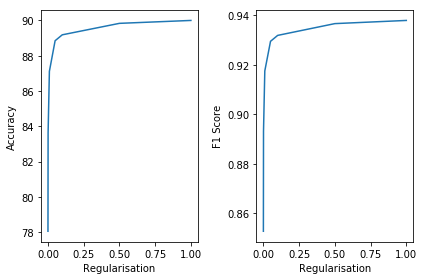

the accuracy value is :  [78.05  83.625 87.115 88.85  89.185 89.835 90.   ]
the F1 score value is :  [0.85277 0.89318 0.91751 0.92948 0.93187 0.93663 0.93791]


In [26]:
plt.subplot(1,2,1)
plt.plot(C,acc_score)
x_val=np.arange(0,len(C))
plt.xlabel('Regularisation')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(C,f1score)
x_val=np.arange(0,len(C))
plt.xlabel('Regularisation')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

print("the accuracy value is : ", np.round(acc_score,5))

print("the F1 score value is : ", np.round(f1score,5))

C=1 gives us the best accuracy as well as F1 score. Let's check this on test data.

In [27]:
LR_BOW=LogisticRegression(penalty='l2',C=1,class_weight='balanced')
LR_BOW.fit(Train_counts,Y_train_Polarity)
## Predict on Validation Data and check error
test_predict=LR_BOW.predict(Test_counts)
## Check Accuracy
test_acc = accuracy_score(Test_data['Score'].values, test_predict) * 100


 ## Convert the string values of actual and prdicted test review into 1 for Positive and 0 for Negative
actual_test=np.array(Test_data['Score'].replace(['Positive','Negative'],[1,0]))
predicted_test=np.array(pd.Series(test_predict).replace(['Positive','Negative'],[1,0]))
## Lets check precision, recall abd F1 score
prec=precision_score(actual_test, predicted_test)
rec=recall_score(actual_test, predicted_test)
f1=f1_score(actual_test,predicted_test)

print("the test accuracy value is : ", np.round(test_acc,5))

print("the test F1 score value is : ", np.round(f1,5))

the test accuracy value is :  89.965
the test F1 score value is :  0.93849


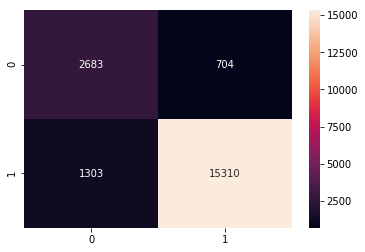

In [28]:
## Plot Confusion Matrix

cm=confusion_matrix(Test_data['Score'].values, test_predict)
ax= plt.subplot()
sn.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [29]:
## Lets also check ROC-AUC for the model
train_roc=roc_auc_score(actual,predicted)
test_roc=roc_auc_score(actual_test,predicted_test)
print('Train AUC:',train_roc)
print('Test AUC:',test_roc)

Train AUC: 0.8640081200795602
Test AUC: 0.8568569447296113


In [30]:
fpr,tpr,_=roc_curve(actual,predicted)

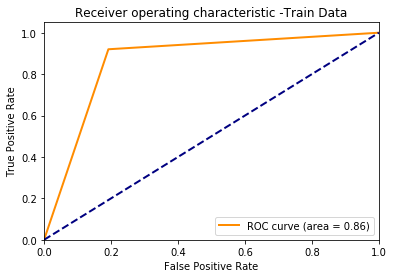

In [31]:
## ROC- AUC Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % train_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic -Train Data')
plt.legend(loc="lower right")
plt.show()

###### Perturbation Test for BOW

In [32]:
Coef=list(LR_BOW.coef_)

In [33]:
Coef=np.array(Coef)

In [34]:
Train_counts.data.shape

(2157596,)

In [35]:
## Perturbation test to check for multicollinearity
## We change the Train Data very slightly and check the % change in coefficients.
## Large change will indicate multicollinearity
epsilon = np.random.normal(loc=0.0, scale=0.000000001)
Train_counts.data=Train_counts.data+epsilon

In [36]:
LR_BOW.fit(Train_counts,Y_train_Polarity)
Coef_chg=list(LR_BOW.coef_)

In [37]:
Coef_chg=np.array(Coef_chg)

In [38]:
#Calculate percent change of weights after perturbation

percent_chg_weights=(abs((Coef[0]-Coef_chg[0])/Coef[0]))*100

In [39]:
# Check the percent change values at different percentiles
np.percentile(percent_chg_weights,np.arange(10,101,10))

array([1.66385588e-03, 3.62939651e-03, 6.43071632e-03, 1.06205309e-02,
       1.87021806e-02, 3.82824648e-02, 9.82367671e-02, 4.53858180e-01,
       1.71068320e+01, 3.63917361e+04])

We see a drastic change in percentage change of weights between 90 and 100 percentile !!

In [40]:
## Zoom in for values between 90-100 percentile
np.percentile(percent_chg_weights,np.arange(90,101,1))

array([1.71068320e+01, 2.97558042e+01, 3.71944876e+01, 3.72830999e+01,
       3.73638500e+01, 3.76796808e+01, 3.84308166e+01, 4.08845929e+01,
       4.67039874e+01, 7.88777364e+01, 3.63917361e+04])

In [41]:
## Zoom in for values between 99 and 100percentile
np.percentile(percent_chg_weights,np.arange(99,100.1,0.1))

array([   78.8777364 ,    86.293696  ,    92.9075169 ,   108.8420775 ,
         129.07468839,   147.5721729 ,   166.90821814,   226.66573775,
         367.96353653,   664.42754112, 36391.73612146])

In [42]:
# Get feature names where change is more than 150% !!!
print(np.take(count_vect.get_feature_names(), np.where(percent_chg_weights>150)))

[['10mos' '110lbs' '1280' '13yrs' '15mgtotal' '15mins' '160total' '1755'
  '18gomega' '200mgyou' '220calories' '240total' '304' '32gdietary' '345'
  '35mgsodium' '3gsugars' '3tablespoons' '4or5' '5mins' '650mg'
  '8gvitamin' 'abated' 'accordinglyper' 'accountant' 'addins' 'ag'
  'ajanta' 'alphabetical' 'andhra' 'aplenty' 'applesuace' 'approximates'
  'astra' 'autoimmune' 'avergage' 'bananaspeacefully' 'banannna'
  'barbecuing' 'beforeall' 'bellas' 'benefitill' 'biscoffs' 'bitesized'
  'bitteraftertaste' 'blissfulness' 'boilable' 'breadi' 'bumblebars'
  'campesterol' 'carnuba' 'caronate' 'carrefour' 'carryout' 'carted'
  'cbs' 'cerevisiae' 'clotted' 'coffeefeb' 'controled' 'corkscrews'
  'crazzetos' 'cubanelle' 'cumin1' 'customizable' 'cutlery' 'darting'
  'defacto' 'dehydtrated' 'diced5' 'diffuser' 'discomforted'
  'discontinuedit' 'disintigrate' 'distinctions' 'docile' 'dreamierpour'
  'drench' 'empacadora' 'emporiums' 'enclosing' 'energetically'
  'enjoymentthis' 'expensivethe' 'fact

The perturbation test shows that even when we change our data slightly there is significant change in the coefficients of some of our features of the model. Thus, we can say that there is some multicollinearity of features.

###### Finding Top Features of the model

In [44]:
class1 = sorted(zip(Coef[0], count_vect.get_feature_names()), reverse=False)[:50]
class2 = sorted(zip(Coef[0], count_vect.get_feature_names()), reverse=True)[:50]
print('Most Negative Words')
print(class1)
print('------------------------')
print('Most Positive Words')
print(class2)

Most Negative Words
[(-3.716950325276662, 'worst'), (-3.52048319644942, 'disappointing'), (-2.9486217483038613, 'hime'), (-2.8618188600151484, 'disappointment'), (-2.761544435164453, 'terrible'), (-2.74006753517029, 'unacceptable'), (-2.694342932071461, 'cocca'), (-2.5518218311964413, 'horrible'), (-2.505271028656819, 'hopes'), (-2.420144743236141, 'ripoff'), (-2.393886492986057, 'flavorless'), (-2.382552461196535, 'overpowered'), (-2.325207222624003, 'pst'), (-2.3059662430204386, 'earths'), (-2.2785680564082424, 'compressa'), (-2.277951836898292, 'failed'), (-2.2258311392907277, 'awful'), (-2.200904896623255, 'sopaipillas'), (-2.18712597466349, 'threw'), (-2.1815075470531498, 'hike'), (-2.170971104138928, 'poison'), (-2.1053711049383437, 'perricone'), (-2.0675349302901633, 'yuck'), (-2.0579239065636665, 'gross'), (-2.052092851709578, 'cosmos'), (-2.0394992252689272, 'puzzeled'), (-2.0259059750744353, 'tasteless'), (-2.0253097826990887, 'sounded'), (-2.023644676079533, 'rip'), (-2.0129

In [39]:
from wordcloud import WordCloud

###### Most imp positive words

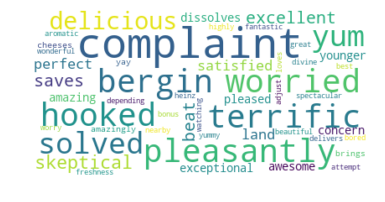

In [51]:
# Create and generate a word cloud image:
pos_weights,pos_words = zip(*class2)
#text_pos=pd.Series(np.take(count_vect.get_feature_names(), pos_coef_sorted[:50]))
text_pos = " ".join(word for word in pos_words)

wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_pos)

# Display the generated image:
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

###### Most imp Negative words

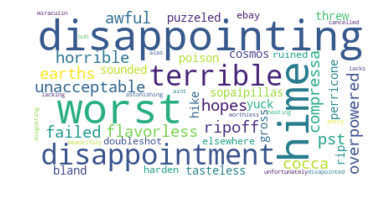

In [52]:
# Create and generate a word cloud image:
neg_weights,neg_words = zip(*class1)
#text_neg=pd.Series(np.take(count_vect.get_feature_names(), neg_coef_sorted[:50]))
text_neg = " ".join(word for word in neg_words)

wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_neg)

# Display the generated image:
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

## Logistic Regression using TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
## Create a tf-idf vectorizer-unigram

## For Train data

tf_idf_vect = TfidfVectorizer(ngram_range=(1,1),dtype='float')
tf_idf_vocab=tf_idf_vect.fit(Train_data['CleanedText'].values) ## Create Vocabulary to be used by Train and Test Data
tf_idf_train_counts=tf_idf_vect.transform(Train_data['CleanedText'].values)
tf_idf_train_counts.get_shape()

(60000, 55102)

In [17]:
## For CV Data
tf_idf_cv_counts=tf_idf_vect.transform(CV_data['CleanedText'].values)
tf_idf_cv_counts.get_shape()

(20000, 55102)

In [18]:
## For Test data
tf_idf_test_counts=tf_idf_vect.transform(Test_data['CleanedText'].values)
tf_idf_test_counts.get_shape()

(20000, 55102)

######  Find Optimal value of Regularisation Parameter C for TF-IDF LR

In [19]:
C=[0.0001,0.001, 0.01,0.05, 0.1,0.5,1]
acc_score_tf=[]
f1score_tf=[]
## Fit Logistic Regression to Train Data
for value in C:
    LR_TF=LogisticRegression(penalty='l2',C=value,class_weight='balanced')
    LR_TF.fit(tf_idf_train_counts,Y_train_Polarity)
    ## Predict on Validation Data and check error
    val_predict=LR_TF.predict(tf_idf_cv_counts)
    ## Check Accuracy
    val_acc = accuracy_score(CV_data['Score'].values, val_predict) * 100
    acc_score_tf.append(val_acc)
    ## Convert the string values of actual and prdicted test review into 1 for Positive and 0 for Negative
    actual=np.array(CV_data['Score'].replace(['Positive','Negative'],[1,0]))
    predicted=np.array(pd.Series(val_predict).replace(['Positive','Negative'],[1,0]))
    ## Lets check precision, recall abd F1 score
    prec=precision_score(actual, predicted)
    rec=recall_score(actual, predicted)
    f1=f1_score(actual,predicted)
    f1score_tf.append(f1)

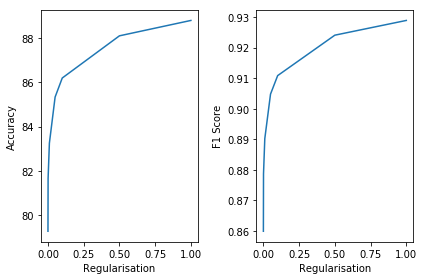

the accuracy value is :  [79.27  81.655 83.245 85.33  86.19  88.095 88.79 ]
the F1 score value is :  [0.8599  0.87871 0.89021 0.90478 0.91083 0.92406 0.92888]


In [20]:
plt.subplot(1,2,1)
plt.plot(C,acc_score_tf)
x_val=np.arange(0,len(C))
plt.xlabel('Regularisation')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(C,f1score_tf)
x_val=np.arange(0,len(C))
plt.xlabel('Regularisation')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

print("the accuracy value is : ", np.round(acc_score_tf,5))

print("the F1 score value is : ", np.round(f1score_tf,5))

###### Using Optimal C to fit LR to Test Data

In [21]:
LR_TF=LogisticRegression(penalty='l2',C=1,class_weight='balanced')
LR_TF.fit(tf_idf_train_counts,Y_train_Polarity)
## Predict on Validation Data and check error
test_predict=LR_TF.predict(tf_idf_test_counts)
## Check Accuracy
test_acc = accuracy_score(Test_data['Score'].values, test_predict) * 100


 ## Convert the string values of actual and prdicted test review into 1 for Positive and 0 for Negative
actual_test=np.array(Test_data['Score'].replace(['Positive','Negative'],[1,0]))
predicted_test=np.array(pd.Series(test_predict).replace(['Positive','Negative'],[1,0]))
## Lets check precision, recall abd F1 score
prec=precision_score(actual_test, predicted_test)
rec=recall_score(actual_test, predicted_test)
f1=f1_score(actual_test,predicted_test)

print("the test accuracy value is : ", np.round(test_acc,5))

print("the test F1 score value is : ", np.round(f1,5))

the test accuracy value is :  89.075
the test F1 score value is :  0.93156


In [22]:
cm_tfidf=confusion_matrix(Test_data['Score'].values, test_predict)

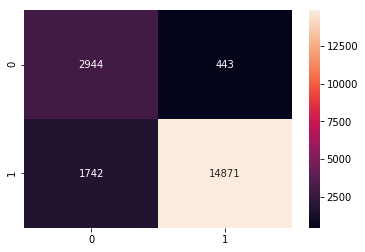

In [23]:
ax= plt.subplot()
sn.heatmap(cm_tfidf, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [24]:
tn, fp, fn, tp = confusion_matrix(Test_data['Score'].values, test_predict).ravel()
print("True Negative :"+str(tn))
print("False Positive :"+str(fp))
print("False Negative :"+str(fn))
print("True positive :"+str(tp))

True Negative :2944
False Positive :443
False Negative :1742
True positive :14871


In [25]:
## Lets also check ROC-AUC for the model
train_roc=roc_auc_score(actual,predicted)
test_roc=roc_auc_score(actual_test,predicted_test)
print('Train AUC:',train_roc)
print('Test AUC:',test_roc)

Train AUC: 0.8808655627727844
Test AUC: 0.8821740726130167


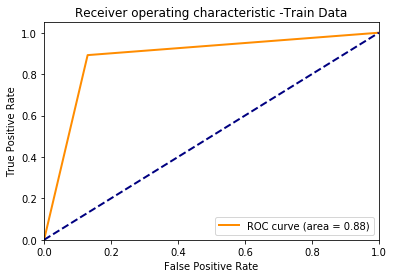

In [26]:
## ROC- AUC Plot
fpr,tpr,_=roc_curve(actual,predicted)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % train_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic -Train Data')
plt.legend(loc="lower right")
plt.show()

######  Perturbation test for TFIDF

In [27]:
# Perturbation test for TFIDF
Coef=np.array(LR_TF.coef_)

In [28]:
## Perturbation test to check for multicollinearity
## We change the Train Data very slightly and check the % change in coefficients.
## Large change will indicate multicollinearity
epsilon = np.random.normal(loc=0.0, scale=0.000000001)
tf_idf_train_counts.data=tf_idf_train_counts.data+epsilon

In [29]:
LR_TF.fit(tf_idf_train_counts,Y_train_Polarity)
Coef_chg=np.array(LR_TF.coef_)

print(Coef[0][:10],Coef_chg[0][:10])
print((Coef[0][1]-Coef_chg[0][1])/Coef[0][1])

[-1.61031844  0.5765034   0.03019529  0.02406471 -0.10479168  0.00901901
  0.01720082  0.06308518  0.03000163 -0.18610847] [-1.61031845  0.5765034   0.03019529  0.02406471 -0.10479168  0.00901901
  0.01720082  0.06308518  0.03000163 -0.18610847]
9.226014391373741e-09


In [30]:
#Calculate percent change of weights after perturbation

percent_chg_weights=(abs((Coef[0]-Coef_chg[0])/Coef[0]))*100

In [31]:
# Check the percent change values at different percentiles
np.percentile(percent_chg_weights,np.arange(10,101,10))

array([1.41662918e-07, 2.90016132e-07, 4.50996409e-07, 6.35463837e-07,
       8.60367516e-07, 1.13446949e-06, 1.54149779e-06, 2.27761652e-06,
       4.22275245e-06, 3.94587818e-03])

In [32]:
## Zoom in for values between 90-100 percentile
np.percentile(percent_chg_weights,np.arange(90,101,1))

array([4.22275245e-06, 4.68685271e-06, 5.28126124e-06, 6.00411744e-06,
       6.99873957e-06, 8.48279907e-06, 1.03560643e-05, 1.34701144e-05,
       2.00341696e-05, 3.85274405e-05, 3.94587818e-03])

In [33]:
## Zoom in for values between 99 and 100percentile
np.percentile(percent_chg_weights,np.arange(99,100.1,0.1))

array([3.85274405e-05, 4.18374559e-05, 4.60431476e-05, 5.17071171e-05,
       6.01000895e-05, 7.26069074e-05, 8.51373493e-05, 1.08101957e-04,
       1.42811525e-04, 2.68096895e-04, 3.94587818e-03])

In [35]:
# Get feature names where change is more than 10% !!!
print(np.take(tf_idf_vect.get_feature_names(), np.where(percent_chg_weights>10)))

[]


For TF-IDF features, we do not see any multicollinearity !!!

###### Finding Top Positive and Negative features (words)

In [37]:
neg_class=sorted(zip(Coef[0],tf_idf_vect.get_feature_names()),reverse=False)[:50]
pos_class=sorted(zip(Coef[0],tf_idf_vect.get_feature_names()),reverse=True)[:50]
print('Most Negative Words')
print(neg_class)
print('------------------------')
print('Most Positive Words')
print(pos_class)

Most Negative Words
[(-8.779225834244196, 'not'), (-8.535463138905952, 'worst'), (-7.453400903793595, 'disappointing'), (-7.207400119077903, 'terrible'), (-6.986837741205296, 'disappointed'), (-6.643822793727058, 'horrible'), (-6.496025422641043, 'unfortunately'), (-6.4245317252897225, 'awful'), (-5.472212521616702, 'disappointment'), (-5.403569015155666, 'bland'), (-5.133699654629939, 'threw'), (-5.046395762883731, 'stale'), (-4.745380615738716, 'weak'), (-4.743683587234398, 'changed'), (-4.563399870441939, 'money'), (-4.409019696550382, 'sorry'), (-4.315479010112865, 'didnt'), (-4.243456940159378, 'return'), (-4.183341601451678, 'poor'), (-4.111407866448873, 'china'), (-4.083835943155175, 'stick'), (-4.0568508800383905, 'waste'), (-4.053370799036138, 'nasty'), (-3.996740400244972, 'gross'), (-3.995779456057204, 'disgusting'), (-3.980628460722881, 'wouldnt'), (-3.9207212795002775, 'rip'), (-3.8477391145586486, 'bad'), (-3.8342464015668583, 'seemed'), (-3.819658068116598, 'thought'), (

In [30]:
## Code snippet found on Stackoverflow
neg_coef_sorted_tf = Coef[0][Coef[0]<0].argsort()
pos_coef_sorted_tf = Coef[0][Coef[0]>0].argsort()

print("Top negative features: ")
print(np.take(tf_idf_vect.get_feature_names(), neg_coef_sorted_tf[::-1][:20]))
print("Top positive features: ")
print(np.take(tf_idf_vect.get_feature_names(), pos_coef_sorted_tf[::-1][:20]))

Top negative features: 
['articles' 'barker' 'angles' 'cholesterolcarbs' '104' 'ablity' 'degass'
 'crud' 'bustello' 'demerara' 'bret' '600' 'abouut' 'daddy' 'coating'
 'crispapparently' '1920' 'contrary' 'dehyrdated' 'coconutty']
Top positive features: 
['easting' 'chuck' 'aspartane' 'jetblue' 'cupwe' 'goingi' 'drm' 'goldman'
 'recipes' 'humanseven' 'ethnicity' 'decidely' 'parcel' 'administered'
 'endangering' 'kevin' 'netting' 'andina' 'contributionsfor' 'reloaded']


###### Top Positive Words

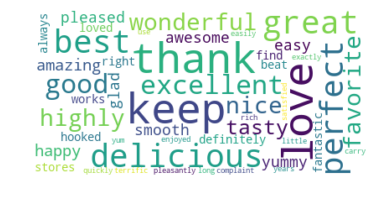

In [40]:
# Create and generate a word cloud image:
pos_weights,pos_words = zip(*pos_class)
#text_pos=pd.Series(np.take(tf_idf_vect.get_feature_names(), pos_coef_sorted_tf[::-1][:50]))
text_pos = " ".join(word for word in pos_words)

wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_pos)

# Display the generated image:
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

###### Top Negative Words

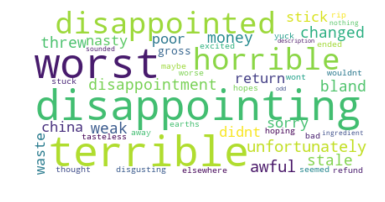

In [41]:
# Create and generate a word cloud image:
neg_weights,neg_words=zip(*neg_class)
#text_neg=pd.Series(np.take(tf_idf_vect.get_feature_names(), neg_coef_sorted_tf[::-1][:50]))
text_neg = " ".join(word for word in neg_words)

wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_neg)

# Display the generated image:
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

## Logistic Regression using Word2Vec

In [35]:
## Split each text row into words for train data
sent_split_train=[sent.split() for sent in Train_data['CleanedText'].values]
print(sent_split_train[0])

['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', '&quot;attracted&quot;', 'many', 'flies', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'flies', 'driving', 'crazy', 'consider', 'buying', 'this', 'one', 'caution-', 'surface', 'very', 'sticky', 'try', 'avoid', 'touching', 'it']


In [37]:
## Train Word2Vec Model.Consider words with min frequency 5.

w2vModel=Word2Vec(sent_split_train,min_count=5,size=100,workers=4)

In [38]:
## W2V Train Vocab
w2v_words_train = list(w2vModel.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  16627
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'this', 'one', 'surface', 'very', 'sticky', 'try', 'avoid', 'touching', 'it', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'beetlejuice', 'wonderfully', 'amusing', 'incredible', 'possibilities', 'absurd']


In [39]:
print(w2vModel.wv.most_similar('good'))

[('decent', 0.7105485200881958), ('great', 0.6940838098526001), ('yummy', 0.6190146207809448), ('awesome', 0.6081677079200745), ('bad', 0.5805352926254272), ('excellent', 0.5737519264221191), ('nice', 0.5692737698554993), ('fantastic', 0.5633279085159302), ('tasty', 0.5482332110404968), ('amazing', 0.5479933023452759)]


In [42]:
## Find Avg Word Vectors for each sentence. Use for both Train,CV and Test Data

def AvgWord2Vec(sent_split):
    '''
    This function takes the sentences from the text and computes avg word vectors.
    input:
    sent_split :List of input sentences split into words for each row of text
    output:
    avg_sent_vectors: List of avg word vectors of dimension 50
    '''
    avg_sent_vectors=[]
    for sent in sent_split:
        sent_vect=np.zeros(100)
        cnt_word=0
        for word in sent:
            if word in w2v_words_train:
                word_vec=w2vModel.wv[word]
                cnt_word+=1
                sent_vect+=word_vec
        if cnt_word != 0:
            sent_vect/=cnt_word
        avg_sent_vectors.append(sent_vect)
    return(avg_sent_vectors)

In [43]:
avg_vectors_train=AvgWord2Vec(sent_split_train)
print(avg_vectors_train[0])

[ 0.11995664 -0.49698349 -0.13133377 -0.05530029  0.12474378  0.50649971
  0.11450389 -0.05391136  0.10695035 -0.49296096  0.61048732 -0.56877628
  0.28599113 -0.26932625 -0.13385679  0.1435591  -0.25931916 -0.07911769
  0.10601075  0.12867856 -0.06769908 -0.34801678 -0.53694756  0.11313273
 -0.06947912  0.20181959  0.15904446  0.22426711  0.07591621 -0.02976353
 -0.32482744  0.08152155 -0.28535021  0.25747533  0.35697257  0.09968906
 -0.20627024  0.19010338 -0.14052901 -0.04892604  0.26994292 -0.31746828
 -0.3500821   0.31230584 -0.10099881 -0.26235934 -0.20726882 -0.1169898
 -0.40498164  0.0238184  -0.07977971 -0.05802904  0.36383687 -0.00682091
  0.03913607  0.04197934  0.23105721  0.19798563 -0.39374163 -0.0627188
  0.2189342  -0.25920393  0.35159668  0.19692199 -0.48823671  0.29344059
  0.3272347  -0.32735835  0.19512651  0.15346128  0.41409995  0.06183806
  0.00860708  0.05722441  0.05925456  0.14125316  0.22796693 -0.04494692
  0.02079979 -0.13424496  0.34288409  0.39593357 -0.3

In [44]:
## Split each text row into words for CV data
sent_split_cv=[sent.split() for sent in CV_data['CleanedText'].values]
print(sent_split_cv[0])

['bought', 'one', 'pet', 'store', 'dog', 'always', 'try', 'give', 'natural', 'minimally-processed', 'chews', 'treats', 'goes', 'lot', 'bully', 'sticks', 'pig', 'ears', '&', 'himalayan', 'chews', 'label', 'didnt', 'say', 'made', '&', 'thought', 'bully', 'stick', 'bit', 'dried', 'bull', 'anatomy', 'like', 'large', 'tendon', 'nice', 'odor-free', 'texture', 'seemed', 'unusual', 'sort', 'soft', '&', 'chewy', 'like', 'heavy', 'dried', 'dough', 'not', 'tough', '&', 'durable', 'like', 'normal', 'bully', 'stick', '20lb', 'bicha-poo', 'ate', 'whole', '12', 'stick', 'half', 'hour', 'looking', 'online', 'discovered', 'not', 'natural', 'meat', 'man-made', 'fake', 'bully', 'stick', 'ingredients', 'potato', 'starch', 'meat', 'product', 'corn', 'starch', 'sorbitol', 'liver', 'cellulose', 'water', 'egg', 'lecithin', 'calcium', 'stearate', 'titanium', 'dioxide', 'caramel', 'color', 'sorbic', 'acid', 'wont', 'buying', 'full', 'weird', 'ingredients', 'not', 'natural', 'not', 'last']


In [45]:
## Split each text row into words for test data
sent_split_test=[sent.split() for sent in Test_data['CleanedText'].values]
print(sent_split_test[0])

['really', 'like', 'taste', 'product', 'feel', 'like', 'helping', 'feel', 'healthier', 'enjoy', 'putting', 'green', 'smoothies']


In [47]:
avg_vectors_cv=AvgWord2Vec(sent_split_cv)
print(avg_vectors_cv[0])

[ 0.12517734 -0.49442777 -0.26763469 -0.21356413 -0.12087594 -0.05624711
  0.20277005 -0.19833248 -0.15649846 -0.05036491  0.13194486  0.01273294
  0.35333225  0.05962224 -0.35336576  0.11569183 -0.2475652  -0.01641879
  0.14698558  0.22999041 -0.16866517 -0.55592609 -0.45941517  0.1905958
  0.01673197 -0.28124422  0.25889028 -0.01938528 -0.00370595 -0.19723943
 -0.32659854  0.0067435  -0.05221272  0.18215703  0.02409234 -0.62928715
  0.03121082 -0.25500642 -0.20930788 -0.06157487  0.06040767 -0.08017667
  0.14542565 -0.17687634 -0.13692626 -0.24462371 -0.39203698 -0.13620392
  0.02743605  0.1250567  -0.18048141  0.17187396  0.20281381 -0.5365778
  0.28603733  0.37860974  0.38503499 -0.03544425 -0.48442348  0.37753768
  0.65047326 -0.1718458   0.08342936  0.03960299 -0.50243351  0.14157263
  0.2234052  -0.14407464 -0.14195746 -0.31544627  0.31614723 -0.27400991
 -0.25774184 -0.16761011  0.37938005  0.19025684  0.52866097 -0.08029441
  0.22203323  0.03636902  0.21018805  0.14793411  0.1

In [48]:
avg_vectors_test=AvgWord2Vec(sent_split_test)
print(avg_vectors_test[0])

[-1.52967343e-01 -7.91011496e-01 -4.02462311e-02 -4.54277538e-01
  1.18977581e-01 -1.54025483e-01  7.56249917e-01 -2.70718988e-01
 -1.86695297e-01 -1.60504171e-01  7.54791279e-01  5.03567753e-01
 -7.28063695e-02 -1.02671095e-01  5.01432642e-03  4.68658095e-01
  1.89351308e-01  4.49185951e-01  5.95265299e-02  1.02463151e+00
  1.50229949e-01 -5.37014817e-01 -6.36280485e-01  1.26014691e-01
  1.71387821e-01 -2.77285714e-01  1.42146986e-01  5.54991679e-01
  1.38395171e-01  4.00029392e-02 -5.15126311e-01  1.87159106e-01
 -8.06858007e-02 -2.40301655e-02 -6.24016829e-01 -9.33245188e-01
  4.58423890e-01 -6.22859578e-01 -6.66203087e-01 -2.48675926e-01
  6.46825192e-02  2.48949637e-01 -3.80950821e-01  2.49561508e-01
 -4.33347414e-01  7.87605048e-01 -6.39301549e-01 -6.38882910e-01
 -7.40617399e-03 -2.86935859e-01 -3.03301444e-01 -1.05184841e-01
  2.38698860e-01 -1.30752853e+00 -1.42214793e-01 -3.66138653e-04
  5.06697068e-01  1.90062510e-01 -6.33917936e-01 -2.77064857e-01
  9.63039562e-01  4.88091

In [139]:
## Instead of repeating code, we convert it to a function ##. Should have done  this earlier !!
def get_optimal_c(train_count_data,cv_count_data):
    C=[0.0001,0.001, 0.01,0.05, 0.1,0.5,1]
    acc_score_n=[]
    f1score_n=[]
    ## Fit Logistic Regression to Train Data
    for value in C:
        LR_TF=LogisticRegression(penalty='l2',C=value,class_weight='balanced')
        LR_TF.fit(train_count_data,Y_train_Polarity)
        ## Predict on Validation Data and check error
        val_predict=LR_TF.predict(cv_count_data)
        ## Check Accuracy
        val_acc = accuracy_score(CV_data['Score'].values, val_predict) * 100
        acc_score_n.append(val_acc)
        ## Convert the string values of actual and prdicted test review into 1 for Positive and 0 for Negative
        actual=np.array(CV_data['Score'].replace(['Positive','Negative'],[1,0]))
        predicted=np.array(pd.Series(val_predict).replace(['Positive','Negative'],[1,0]))
        ## Lets check precision, recall abd F1 score
        prec=precision_score(actual, predicted)
        rec=recall_score(actual, predicted)
        f1=f1_score(actual,predicted)
        f1score_n.append(f1)
    return (tuple(zip(acc_score_n,f1score_n)))

In [142]:
acc_score_w2v,f1score_w2v=zip(*get_optimal_c(avg_vectors_train,avg_vectors_cv))
acc_score_w2v=list(acc_score_w2v)
f1score_w2v=list(f1score_w2v)

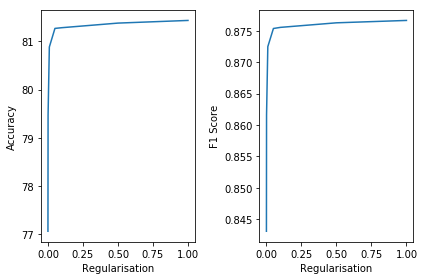

the accuracy value is :  [77.065 79.47  80.88  81.265 81.28  81.375 81.43 ]
the F1 score value is :  [0.84308 0.8616  0.87247 0.87535 0.87553 0.87626 0.87664]


In [143]:
plt.subplot(1,2,1)
plt.plot(C,acc_score_w2v)
x_val=np.arange(0,len(C))
plt.xlabel('Regularisation')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(C,f1score_w2v)
x_val=np.arange(0,len(C))
plt.xlabel('Regularisation')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

print("the accuracy value is : ", np.round(acc_score_w2v,5))

print("the F1 score value is : ", np.round(f1score_w2v,5))

###### Check Test data using optimal C

In [84]:
## Check on Test data using optimal C
LR_w2v=LogisticRegression(penalty='l1',C=1,class_weight='balanced')
LR_w2v.fit(avg_vectors_train,Y_train_Polarity)
## Predict on Validation Data and check error
test_predict=LR_w2v.predict(avg_vectors_test)
## Check Accuracy
test_acc = accuracy_score(Test_data['Score'].values, test_predict) * 100


 ## Convert the string values of actual and prdicted test review into 1 for Positive and 0 for Negative
actual_test=np.array(Test_data['Score'].replace(['Positive','Negative'],[1,0]))
predicted_test=np.array(pd.Series(test_predict).replace(['Positive','Negative'],[1,0]))
## Lets check precision, recall abd F1 score
prec=precision_score(actual_test, predicted_test)
rec=recall_score(actual_test, predicted_test)
f1=f1_score(actual_test,predicted_test)

print("the test accuracy value is : ", np.round(test_acc,5))

print("the test F1 score value is : ", np.round(f1,5))

the test accuracy value is :  81.845
the test F1 score value is :  0.88097


In [85]:
cm_w2v=confusion_matrix(Test_data['Score'].values, test_predict)

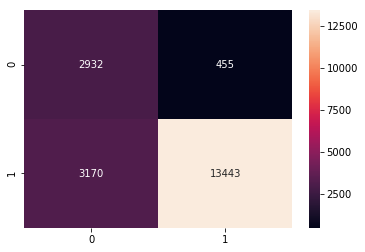

In [86]:
ax= plt.subplot()
sn.heatmap(cm_tfidf, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [87]:
## Lets also check ROC-AUC for the model
train_roc=roc_auc_score(actual,predicted)
test_roc=roc_auc_score(actual_test,predicted_test)
print('Train AUC:',train_roc)
print('Test AUC:',test_roc)

Train AUC: 0.8808655627727844
Test AUC: 0.837243621538413


Both L1 and L2 regularisation give same performance on test data

## LR with TF-IDF weighted Word2vec 

In [123]:
# we are converting a dictionary with word as a key, and the idf as a value 
## Code snippet from AAIC notebook

dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [124]:
## Clean '-' from sentences
import re
def clean_wrd(wrd):
    cleanhash=re.compile('-')
    cleanwrd=re.sub(cleanhash,'',wrd)
    return cleanwrd

In [125]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[0:100])

some sample features(unique words in the corpus) ['00', '000', '0000', '0000soo', '000mg', '000s', '001', '002', '003', '006', '0069615', '00dollars', '00gr', '00i', '00lb', '00the', '00would', '01', '013', '016', '017', '02', '02027c', '020phosphorous', '022', '025', '029', '03', '030', '031', '032', '033', '035', '03510', '039', '04', '040', '042', '045', '046', '04691', '0472066978', '0475', '04820', '04shipping', '05', '051', '055', '05608', '05edit', '05oz', '06', '0631', '06sep11', '07', '0738551856', '07i', '08', '080', '0810', '089', '08m07c0', '08oz', '08sad', '09', '090', '0937', '0f', '0g', '0g12', '0g5', '0gcarbohydrates', '0gcholest', '0gcholesterol', '0gdietary', '0gmonounsat', '0gmonounsaturated', '0gpolyunsat', '0gpolyunsaturated', '0gprotein', '0gsaturated', '0gsodium', '0gsugars', '0gtrans', '0gvitamin', '0if', '0mg', '0mgpotassium', '0mgsodium', '0mgtotal', '0n', '0ne', '0oz', '0total', '0z', '10', '100', '1000', '10000', '100000']


In [193]:
def AvgWord2Vectfidf(sent_split):
    '''
    This function takes the sentences from the text and tf idf counts and computes tf idf weighted word vectors.
    input:
    sent_split :List of input sentences split into words for each row of text and tf idf counts
    output:
    tf_idf_sent_vectors: List of tf idf weighted word vectors of dimension 50
    '''
    tf_idf_sent_vectors=[]
    for sent in sent_split:
        sent_vec=np.zeros(100)
        weight_sum=0
        for word in sent:
            word=clean_wrd(word)
            if word in w2v_words_train:
                word_vec=w2vModel.wv[word]
                try:
                    #tf_idf = tf_idf_counts[row, features.index(word)]
                    tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                    sent_vec += (word_vec * tf_idf)
                    weight_sum += tf_idf
                except:
                    continue
        if weight_sum != 0:
            sent_vec/=weight_sum
        tf_idf_sent_vectors.append(sent_vec)
    return(tf_idf_sent_vectors)

In [194]:
tf_idf_vectors_train=AvgWord2Vectfidf(sent_split_train)
print(len(tf_idf_vectors_train))

60000


In [199]:
tf_idf_vectors_test=AvgWord2Vectfidf(sent_split_test)
print(len(tf_idf_vectors_test))

20000


In [196]:
tf_idf_vectors_cv=AvgWord2Vectfidf(sent_split_cv)
print(len(tf_idf_vectors_cv))

20000


In [197]:
acc_score_w2v_tf,f1score_w2v_tf=zip(*get_optimal_c(tf_idf_vectors_train,tf_idf_vectors_cv))
acc_score_w2v_tf=list(acc_score_w2v_tf)
f1score_w2v_tf=list(f1score_w2v_tf)

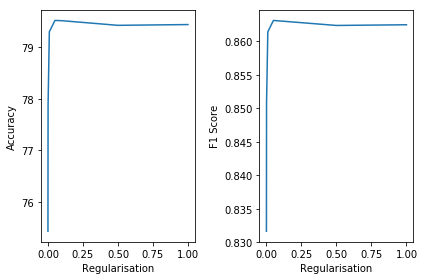

the accuracy value is :  [75.43  77.88  79.305 79.525 79.52  79.43  79.445]
the F1 score value is :  [0.83163 0.85076 0.86143 0.86314 0.86306 0.86239 0.86249]


In [198]:
plt.subplot(1,2,1)
plt.plot(C,acc_score_w2v_tf)
x_val=np.arange(0,len(C))
plt.xlabel('Regularisation')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(C,f1score_w2v_tf)
x_val=np.arange(0,len(C))
plt.xlabel('Regularisation')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

print("the accuracy value is : ", np.round(acc_score_w2v_tf,5))

print("the F1 score value is : ", np.round(f1score_w2v_tf,5))

###### Check on Test Data using optimal value of C

In [205]:
## Check on Test data using optimal C
LR_w2vtf=LogisticRegression(penalty='l2',C=1,class_weight='balanced')
LR_w2vtf.fit(tf_idf_vectors_train,Y_train_Polarity)
## Predict on Validation Data and check error
test_predict=LR_w2vtf.predict(tf_idf_vectors_test)
## Check Accuracy
test_acc = accuracy_score(Test_data['Score'].values, test_predict) * 100


 ## Convert the string values of actual and prdicted test review into 1 for Positive and 0 for Negative
actual_test=np.array(Test_data['Score'].replace(['Positive','Negative'],[1,0]))
predicted_test=np.array(pd.Series(test_predict).replace(['Positive','Negative'],[1,0]))
## Lets check precision, recall abd F1 score
prec=precision_score(actual_test, predicted_test)
rec=recall_score(actual_test, predicted_test)
f1=f1_score(actual_test,predicted_test)

print("the test accuracy value is : ", np.round(test_acc,5))

print("the test F1 score value is : ", np.round(f1,5))

the test accuracy value is :  79.665
the test F1 score value is :  0.8659


In [206]:
cm_w2vtf=confusion_matrix(Test_data['Score'].values, test_predict)

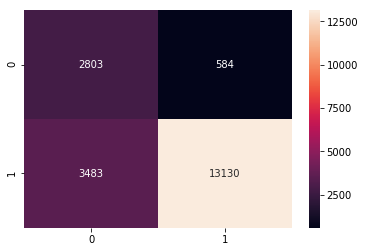

In [208]:
ax= plt.subplot()
sn.heatmap(cm_w2vtf, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [210]:
## Lets also check ROC-AUC for the model
train_roc=roc_auc_score(actual,predicted)
test_roc=roc_auc_score(actual_test,predicted_test)
print('Train AUC:',train_roc)
print('Test AUC:',test_roc)

Train AUC: 0.8808655627727844
Test AUC: 0.8089604682969329


## Conclusion

| Model | C | Test Acc |Test F1 |Test AUC|
|-------|-----|----|----|---|
| BOW |1.0 |90%| 0.94|86% |
| TF-IDF | 1.0|89.07% |0.93 |88.21% |
|Avg W2V| 1.0|81.84% | 0.88|83.72% |
|Tf-Idf W2V| 1.0|79.67% | 0.86|81% |

* Comparing all the 3 metrics, it seems that the TF-IDF model performs better on test data